# Notebook

In the Model learning step, the prepared dataset from [3_Imputing](https://raw.githubusercontent.com/Rudinius/Bike_usage_Bremen/main/3_Imputing.ipynb) is loaded. Then different machine learning algorithms are trained and compared to each other.

We will test
* XGBoost
* Multilayer perceptron (MLP)
* Recurrent Neural Network (RNN)

<a name="content"></a>
# Content

* [1. Import libraries](#1.)
* [2. Import datasets](#2.)
* [3. Select a target station](#3.)
* [4. Establish baseline benchmark](#4.)
* [5. Selecting features, splitting the data, standardizing](#5.)
* [6. Training machine learning algorithms](#6.)
    * [6.1. Consideration reagarding sequential data](#6.1.)
    * [6.2. XGBoost](#6.2.)
    * [6.3. Multilayer perceptron](#6.3.)
    * [6.4. Recurrent Neural Network](#6.4.)
* [7. Summary and conclusion](#7.)

<a name="1."></a>
# 1.&nbsp;Import libraries
[Content](#content)

In [1]:
# Only used for suppressing warning due to google colab environment
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit#, #cross_val_score,
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Bidirectional, Reshape
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

In [4]:
# Install package shap since it is not part of the standard packages
# of Google Colab

import importlib

# Check if package is installed
package_name = ["shap"]

for package in package_name:
    spec = importlib.util.find_spec(package)
    if spec is None:
        # Package is not installed, install it via pip
        !pip install {package}
    else:
        print(f"{package} is already installed")

    shap = importlib.import_module(package)

shap is already installed


In [5]:
keras.utils.set_random_seed(1)

<a name="2."></a>
#2.&nbsp;Import dataset
[Content](#content)

Import the processed dataset.

In [6]:
# Set base url
url = "https://raw.githubusercontent.com/Rudinius/Bike_usage_Bremen/main/data/"

In [7]:
# Import dataset

# We will also parse the date column as datetime64 and set it to the index column
df = pd.read_csv(url + "03_training_data/" + "2023-08-24_processed_df.csv",
                         parse_dates=[0], index_col=[0])

# Check the correct loading of dataset
df.head()

,graf_moltke_straße_ostseite,graf_moltke_straße_westseite,hastedter_bruckenstraße,langemarckstraße_ostseite,langemarckstraße_westseite,osterdeich,radweg_kleine_weser,schwachhauser_ring,wachmannstraße_auswarts_sud,wachmannstraße_einwarts_nord,...,holiday_2_weihnachtsfeiertag,holiday_christi_himmelfahrt,holiday_karfreitag,holiday_neujahr,holiday_ostermontag,holiday_pfingstmontag,holiday_reformationstag,holiday_tag_der_arbeit,holiday_tag_der_deutschen_einheit,transformed_vacation
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,261.0,290.0,381.0,312.0,308.0,870.0,410.0,391,514.0,267.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-02,750.0,876.0,1109.0,1258.0,1120.0,2169.0,1762.0,829,1786.0,1456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-03,931.0,1015.0,1603.0,1556.0,1480.0,2295.0,2287.0,1196,2412.0,2035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-04,500.0,587.0,1284.0,703.0,626.0,1640.0,1548.0,1418,964.0,702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-05,1013.0,1011.0,0.0,1856.0,1621.0,4128.0,4256.0,3075,2065.0,1377.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


<a name="3."></a>
# 3.&nbsp;Select a target station
[Content](#content)


There are many stations that we could train our model on. Also we could add up all stations to a column `total` and try to predict the overall number in the city per day. However this approach would average many values which would lead on side to less noisy data as single outliers would be less impactful. On the other side it would also average over indivdual patterns.

For this reason, we choose a single station to train our model on. For real-life purposes better results could be expected with one model per station.

For the further process, we will work with the station: `wilhelm_kaisen_brucke_ost`


In [8]:
target = "imputed_wilhelm_kaisen_brucke_ost"

<a name="4."></a>
# 4.&nbsp;Establish baseline benchmark
[Content](#content)


For our current task of creating model a to predict the amount of cyclers for a given day, we do not have any baseline metric score to measure our model against.
For this reason, we will create a naive baseline model. For this, we will simply predict the amount of a day based on the value of previous day.

In [9]:
# Calculate RMSE between two columns shifted by one day
rmse = np.sqrt(mean_squared_error(df[target].iloc[:-1], df[target].shift(-1).iloc[:-1]))
print("RMSE: %f" % (rmse))

RMSE: 2346.990813


If we were naivly predicting the current value with the last value, we get an error over the entire dataset of approximately $2.347$. This is our naive benchmark to compare our model against.

Another method would be to predict the value of a given day by the average of all the other equal days in the dataset (e.g., to predict 18.08.2017, we take the average of all other 18.08. days in the dataset).

In [10]:
# Initialize squared error
se = 0

# Get the total number of examples
m = df.shape[0]

for i in df.index:
    day = i.day
    month = i.month
    year = i.year

    # create a mask for given day but exclude the day we want to predict
    mask = (df.index.day == day) & (df.index.month == month) & (df.index.year != year)

    # Get value for current day and mean values of all the other same days in the dataset
    y = df.loc[i, target]
    y_hat = df.loc[mask, target].mean()

    # Calculate the squared error
    se += (y - y_hat)**2

# Calculate mean squared error
mse = se / m

# Calcualte root mean squared error
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 2033.3351259991568


With this second approach, of average all our previous values for the given day and using this as our forecast, we get an error over the entire dataset of approximately $2,033$.

The error of this second naive approach is close to the first approach.
Both approaches could be seen as human-level as this would be a typical approach of a human, to predict the value of any given day. A domain expert, who also looks at more data and e.g., compares also the temperatures, could come up with better estimates. However humans are typically not very good in accurately predicting complex time-series data. The expected Bayes error (least possible error) should therefore be much lower.

<a name="5."></a>
# 5.&nbsp;Selecting features, splitting the data, standardizing
[Content](#content)

First we select all the features we want to use for our training. During the EDA step, we already decided to exclude some features. However it can always be checked, if some of the features might not add a benefit.

In [11]:
# Higly correlated features have been removed (tavg, tmin, imputed_wpgt)
# Features with no correlation have been removed (imputed_wdir, wdir_sin, wdir_cos)
# Only all single couting stations are being removed

features_date = [
    'year',
    'month',
    'day',
    'weekday',
]

features_sin_cos_transformation = [
    'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    'year_sin', 'year_cos',
]

features_weather = [
    'tmax',
    'prcp',
    'imputed_snow',
    'wspd',
    'pres',
    'tsun',
    ]

features_holidays_vacation = [
    'holiday_1_weihnachtsfeiertag', 'holiday_2_weihnachtsfeiertag',
    'holiday_christi_himmelfahrt', 'holiday_karfreitag', 'holiday_neujahr',
    'holiday_ostermontag', 'holiday_pfingstmontag',
    'holiday_reformationstag', 'holiday_tag_der_arbeit',
    'holiday_tag_der_deutschen_einheit', 'transformed_vacation'
    ]

# Target is 'imputed_wilhelm_kaisen_brucke_ost'
target = target

In [12]:
# Put the features togehter and check if feature vector is correct
features = features_sin_cos_transformation + features_weather + features_holidays_vacation
features

['week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
 'year_sin',
 'year_cos',
 'tmax',
 'prcp',
 'imputed_snow',
 'wspd',
 'pres',
 'tsun',
 'holiday_1_weihnachtsfeiertag',
 'holiday_2_weihnachtsfeiertag',
 'holiday_christi_himmelfahrt',
 'holiday_karfreitag',
 'holiday_neujahr',
 'holiday_ostermontag',
 'holiday_pfingstmontag',
 'holiday_reformationstag',
 'holiday_tag_der_arbeit',
 'holiday_tag_der_deutschen_einheit',
 'transformed_vacation']

Now, we will split the data into a training set, a dev set and a test set.

When splitting into train, dev and test set, we will not shuffle the data. This ensures that the validation results are more realistic since they are being evaluated on the data collected after the model was trained. Otherwise we would introduce a "leakage error" into our data.

In [13]:
# Split the data into training and dev sets
# We set shuffle to False

# Split full dataset 80/20 (~8 years to 2 years)
X_train, X_temp, y_train, y_temp = train_test_split(df[features], df[target],
                                                    test_size=0.2, shuffle=False, random_state=0)
# Split smaller dataset again 50/50 (~1 year each)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp,
                                                    test_size=0.5, shuffle=False, random_state=0)

# Check the beginning end of each dataset
print("X_train: ", X_train[features].shape, "y_train: ", y_train.shape)
print("X_train first day: ", X_train.index.date[0], "and last day: ", X_train.index.date[-1])
print("y_train first day: ", y_train.index.date[0], "and last day: ", y_train.index.date[-1])
print("X_dev: ", X_dev[features].shape, "y_dev: ", y_dev.shape)
print("X_dev first day: ", X_dev.index.date[0], "and last day: ", X_dev.index.date[-1])
print("y_dev first day: ", y_dev.index.date[0], "and last day: ", y_dev.index.date[-1])
print("X_test: ", X_test[features].shape, "y_test: ", y_test.shape)
print("X_test first day: ", X_test.index.date[0], "and last day: ", X_test.index.date[-1])
print("y_test first day: ", y_test.index.date[0], "and last day: ", y_test.index.date[-1])

X_train:  (2921, 23) y_train:  (2921,)
X_train first day:  2013-01-01 and last day:  2020-12-30
y_train first day:  2013-01-01 and last day:  2020-12-30
X_dev:  (365, 23) y_dev:  (365,)
X_dev first day:  2020-12-31 and last day:  2021-12-30
y_dev first day:  2020-12-31 and last day:  2021-12-30
X_test:  (366, 23) y_test:  (366,)
X_test first day:  2021-12-31 and last day:  2022-12-31
y_test first day:  2021-12-31 and last day:  2022-12-31


Finally, we will standardize our dataset. Standarization will generally improve learning speed of the models and can help to improve the accuarcy of the model.

In [14]:
# Standardize and fit to the training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same standardization to the dev set
X_dev_scaled = scaler.transform(X_dev)

# Apply the same standardization to the test set
X_test_scaled = scaler.transform(X_test)

<a name="6."></a>
# 6.&nbsp;Training machine learning algorithms
[Content](#content)

We are going to train 1 shallow machine learning algorithm and 2 deep machine learning algorithms to be able to compare performances. Those are:

* XGBoost
* Multilayer Perceptron (MLP -- standard NN)
* Recurrent Neural Network (RNN)

<a name="6.1."></a>
## 6.1. Consideration regarding sequential data

[Content](#content)

In contrast to RNNs where the algorithm takes the datapoints of previous timesteps into account, XGBoost and MLPs do not have direct access to the sequential data of previous time steps.
Those algorithms have only indirect knowledge via the learned model parameters. RNNs however directly include the previous timestep for learning the parameters of the current timestep.

Therefore in step of feature engineering, we could add features (e.g., the amount of cyclers of the previous three days) to the dataset. This was tested but only had marginal improvements.

The dataset consists of timeseries data but it does not appear to be overly depended on the previous datapoints. This means, that the amount of cyclers on a previous day, has no direct impact on today. E.g., if the previous day was a sunny and warm Sunday which caused many people to go outside and ride bicycle, it has no huge impact on today. Much more relevant would be that today is a Monday following the Sunday (which is already encoded in the features) and what the weather is like today and not what is was yesterday.  

Therefore we will not include those features. The function to create those features can be found below nevertheless and can be tested.

In [ ]:
# utils
def create_lag_features(df, feature, num_lag=3):
    """
        Function that takes a dataframe, feature and num_lag and return the
        the dataframe with n=num_lag new columns and values shifted by num_lag

        Args:
            df (pandas.DataFrame): datafrane to be changed
            feature (str): name of the feature to be changed
            num_lag (int): number of timesteps (lags)

    """

    num_lag = num_lag

    for i in range(1, num_lag+1):

        name_lag_feature = f"{i}_lag_{feature}"
        df[name_lag_feature] = df[feature].shift(i)

#create_lag_features(df, target, num_lag=3)
#df[[target, f"1_lag_{target}", f"2_lag_{target}", f"3_lag_{target}"]].head()

<a name="6.2."></a>
## 6.2. XGBoost
[Content](#content)

<a name="6.2.1"></a>
### 6.2.1 Using GridSeachCV to select the optimal parameters
[Content](#content)

We will use `GridSearchCV` to select optimal parameters among the preselected ranges for the training data. Furthermore we will create our own scoring metric, to evaluate the performance of the parameters found with `GridSearchCV`.

`GridSearchCV` is using `KFold` for regression problems as default. However `KFold` would split the training data in such a way, that later data will be evaluated against earlier data, introducing `leackage error`.
Therefore we do not use the default, but create splits with `TimeSeriesSplit` and pass this to `GridSearchCV`.

In [15]:
# Create custom function for evaluating GridSearchCV
def custom_rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

# Create the scoring object using the custom scoring function
custom_scorer_rmse = make_scorer(custom_rmse)

In [ ]:
params = {
    'n_estimators': [100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [4, 6, 8],                 # max. depth of tree
    'reg_alpha': [1.0, 5.0, 10.0, 15.0],    # L1 regularization
    'reg_lambda': [1.0, 5.0, 10.0, 15.0],   # L2 regularization#
    'colsample_bytree': [0.8, 0.9],         # subsample ratio of columns
}
"""
'min_child_weight': [3, 6, 12],     # min. weight for splitting into new node
    'colsample_bytree': [0.7, 0.8],     # subsample ratio of columns
"""

#utils
def xgb_parameter_grid_search(X, y, params, custom_scorer):
    """
        Function that uses GridCV Search to search for the best paramters
        for fitting a XGB regressor model using TimeSeriesSplit
        Args:
            X (ndarray): features to be split
            y (ndarray): targets to be split
            params (dict): searchable parameter
            custom_scorer (sklearn.metrics.make_scorer): custom scorer

        Return:
            model, score, params (tupel): best found model, with best score and
                                            params
    """

    def creating_splits(X ,num_splits=4):
        """
            Function creates n consecutive split with TimeSeriesSplit
            Args:
                X (ndarray): data to be split
                num_splits (int): amount of splits

            Return:
                splits (ndarray): array of tuples with index for train and test
        """
        # Getting time series splits using TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits = num_splits)
        splits = []

        for i, (train_index, test_index) in enumerate(tscv.split(X)):
            splits.append((train_index, test_index))

        return splits

    # Create consecutive splits
    splits = creating_splits(X_train_scaled ,num_splits=4)

    # Define the estimator
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

    # Define GridSearch and fit GridSearch on the training data with the custom scorer and custom splits
    grid_search = GridSearchCV(xg_reg, param_grid=params, cv=splits, scoring=custom_scorer_rmse, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    return (grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_)

#model, score, params = xgb_parameter_grid_search(X_train_scaled, y_train, params, custom_scorer_rmse)
#print(model, score, params)

<a name="6.2.2"></a>
### 6.2.2 Train the model and evaluate
[Content](#content)

In [32]:
# Build the XGBoost regressor model with selected hyper parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', reg_alpha = 10.0, reg_lambda = 1.0, learning_rate = 0.1)

""", colsample_bytree = 0.5, learning_rate = 0.05,
                          max_depth = 8, n_estimators = 1000, reg_alpha = 10.0, reg_lambda = 40.0,
                          subsample = 0.8, min_child_weight=5"""

#{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 5.0, 'reg_lambda': 10.0}
# best reg_alpha = 10.0, reg_lambda = 1.0, learning_rate = 0.1)
#'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 1.0, 'reg_lambda': 15.0
xg_reg.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_dev_scaled, y_dev)], verbose=False)

# Evaluate the model's performance using RMSE

# Training set
# Predict on the train set
y_train_hat = xg_reg.predict(X_train_scaled)
rmse_train = custom_rmse(y_train, y_train_hat)
print("Train RMSE: %f" % (rmse_train))

# Dev set
# Predict on the dev set
y_dev_hat = xg_reg.predict(X_dev_scaled)
rmse_dev = custom_rmse(y_dev, y_dev_hat)
print("Dev RMSE: %f" % (rmse_dev))

# Test set
# Predict on the test set
y_test_hat = xg_reg.predict(X_test_scaled)
rmse_test = custom_rmse(y_test, y_test_hat)
print("Test RMSE: %f" % (rmse_test))

Train RMSE: 820.721704
Dev RMSE: 1544.159983
Test RMSE: 1400.010241


In [33]:
# Retrieve performance metrics
results = xg_reg.evals_result()

# Create the array for the x axis, starting from 1
n_trees = np.arange(0, len(results["validation_0"]["rmse"]))
train_rmse = results["validation_0"]["rmse"]
dev_rmse = results["validation_1"]["rmse"]

# Create a line chart with two lines using Plotly Express
fig = px.line(title='train RMSE vs. dev RMSE')
fig.add_scatter(x=n_trees, y=train_rmse, mode='lines+markers', name='Train RMSE', line=dict(color='red'))
fig.add_scatter(x=n_trees, y=dev_rmse, mode='lines+markers', name='Dev RMSE', line=dict(color='blue'))


# Set chart title and axis labels
fig.update_layout(
    xaxis_title='Number of trees',
    yaxis_title='RMSE'
)

# Show the chart
fig.show()

To get an understanding of our model and also to check for plausibility (e.g., did the model pick up correct patterns) we plot the feature importance with the `shap` library.

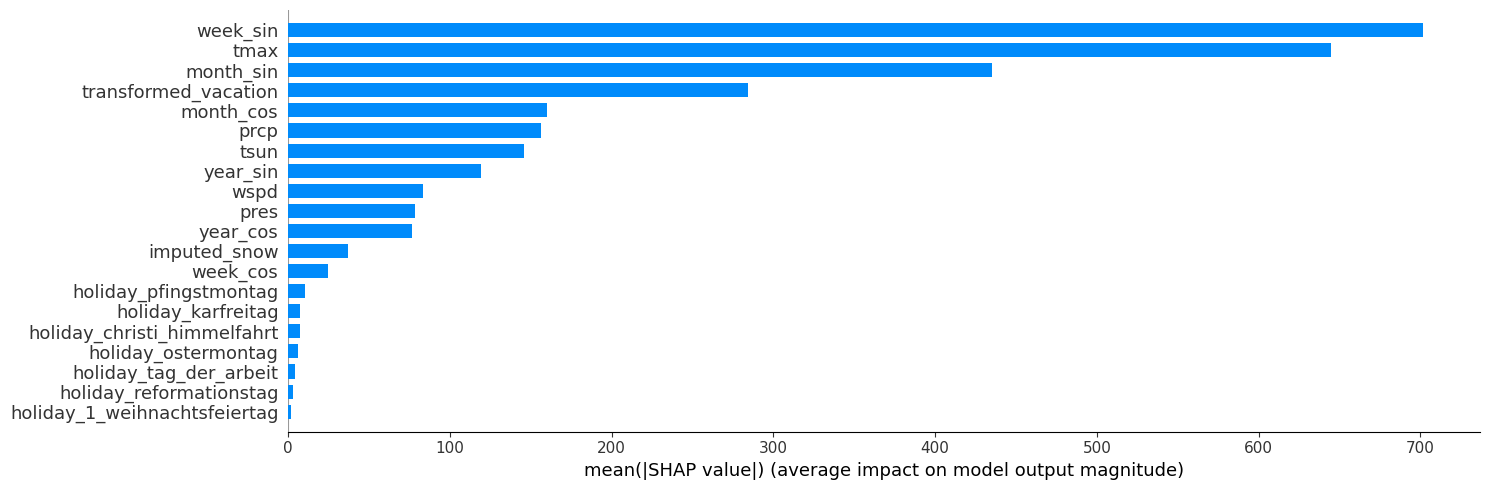

In [191]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_train_scaled)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_train_scaled, feature_names=features, plot_type='bar', plot_size=[15,5])

This plot tells us, that the most important features for the model output are `week_sin`, `tmax`, `month_sin`, and `transformed_vacation`. This seems reasonable since we have seen a weekly periodicity and `tmax` having the highest correlation.

<a name="6.2.3"></a>
### 6.2.3 Results
[Content](#content)

The best RMSE score of our baseline models is $2.033$. With the simple XGBoost model we were able to get a RMSE score of $1.544$ for the dev set and even a RMSE score of $1.400$ for the test set. The better performance for the test set, could be due to a greater similarity of the year 2022 to the training period compared to the year 2021.

Our model performs therefore $31\%$ better than our best baseline model. The most important features for this are the weekly and monthly periodicity and the maximum temperature forecast as well as the label vacation.

<a name="6.3."></a>
## 6.3. Multilayer Perceptron
[Content](#content)

In [ ]:
dropout = 0.2 # 0.2 best

# Define the architecture of the MLP with L2 regularization
model_mlp = Sequential()

model_mlp.add(Input(shape=(len(features),)))
model_mlp.add(Dense(units=128, activation='relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(units=64, activation='relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(units=1, activation='linear'))  # Output layer with 1 neuron for regression

# Compile the model with mean squared error (MSE) loss, and root mean square error (RMSE) as metric
# Use Adam optimizer with learning rate
optimizer = Adam(learning_rate=0.01)
model_mlp.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model_mlp.summary())

# Train the model and save the learning history, use x_dev and y_dev for validation
history = model_mlp.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_dev_scaled, y_dev))

all features with cos and sin
Epoch 100/100
92/92 [==============================] - 0s 3ms/step - loss: 2264314.0000 - root_mean_squared_error: 1504.7638 - val_loss: 2452808.2500 - val_root_mean_squared_error: 1566.1444

In [ ]:
# Create the array for the x axis, starting from 1
epochs = np.arange(1, len(history.history["root_mean_squared_error"])+1)
train_rmse = history.history["root_mean_squared_error"]
dev_rmse = history.history["val_root_mean_squared_error"]

# Create a line chart with two lines using Plotly Express
fig = px.line(title='train RMSE vs. dev RMSE')
fig.add_scatter(x=epochs, y=train_rmse, mode='lines+markers', name='Train RMSE', line=dict(color='red'))
fig.add_scatter(x=epochs, y=dev_rmse, mode='lines+markers', name='Dev RMSE', line=dict(color='blue'))


# Set chart title and axis labels
fig.update_layout(
    xaxis_title='Epochs',
    yaxis_title='RMSE'
)

# Show the chart
fig.show()

In [ ]:
# Explain model predictions using shap library:
explainer = shap.DeepExplainer(model_mlp, X_train_scaled)
shap_values = explainer.shap_values(X_train_scaled)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_train_scaled, feature_names=features, plot_type='bar', plot_size=[15,5])

In [ ]:
# Evaluate the model's performance using RMSE on train
y_train_hat = model_mlp.predict(X_train_scaled)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
print("Train RMSE: %f" % (rmse_train))

# Evaluate the model's performance using RMSE on dev
y_dev_hat = model_mlp.predict(X_dev_scaled)
rmse_dev = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
print("Dev RMSE: %f" % (rmse_dev))

# Evaluate the model's performance using RMSE on test
y_test_hat = model_mlp.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
print("Test RMSE: %f" % (rmse_test))

<a name="6.4."></a>
## 6.4. Recurrent Neural Network
[Content](#content)

Lastly, we train an RNN to compare to the previous two models. A RNN can take in multiple timesteps, to make a prediction (Many-to-One). Specifically, we will feed in 4 timesteps at a time (current day and the 3 previous days) and output the prediction of the current day.

Out input shape is therefore (none, 4, 21), where none represents a variable amount of training days (in our case the length of X_train).

In [34]:
y_dev[:10]
#X_train[:10]

date
2020-12-31     2676.0
2021-01-01     2175.0
2021-01-02     2168.0
2021-01-03     6828.0
2021-01-04     6305.0
2021-01-05     3872.0
2021-01-06    10398.0
2021-01-07     7953.0
2021-01-08     2765.0
2021-01-09     9202.0
Name: imputed_wilhelm_kaisen_brucke_ost, dtype: float64

In [39]:
from keras.utils import timeseries_dataset_from_array

seq_length = 4

#input_data = X_train_scaled
#targets = y_train[3:]
#targets = y_train
"""
a_X_train = X_train_scaled[:-seq_length]
a_y_train = y_train[seq_length-1:]

a_X_dev = X_dev_scaled[:-seq_length]
a_y_dev = y_dev[seq_length-1:]

a_X_test = X_test_scaled[:-seq_length]
a_y_test = y_test[seq_length-1:]"""

dataset_X_train = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_scaled, targets=None, sequence_length=seq_length, batch_size=32, shuffle=False)

dataset_y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=y_train, targets=None, sequence_length=seq_length, batch_size=32, shuffle=False)

dataset_train = tf.data.Dataset.zip((dataset_X_train, dataset_y_train))

dataset_X_dev = tf.keras.utils.timeseries_dataset_from_array(
    data=X_dev_scaled, targets=None, sequence_length=seq_length, batch_size=32, shuffle=False)

dataset_y_dev = tf.keras.utils.timeseries_dataset_from_array(
    data=y_dev, targets=None, sequence_length=seq_length, batch_size=32, shuffle=False)

dataset_dev = tf.data.Dataset.zip((dataset_X_dev, dataset_y_dev))
#print(dataset.take(10))

for x,y in dataset_dev.take(1):
    print(x, y)
"""

#for x, y in dataset.take(10):
#    print(x, y)

y_trainnnn = tf.keras.utils.timeseries_dataset_from_array(
    data=targets, targets=None, sequence_length=4, batch_size=None, shuffle=False)


for y in y_trainnnn.take(10):
    print(y)

x_trainnnn.to_numpy()"""


tf.Tensor(
[[[ 6.12636142e-01 -1.27460169e+00 -1.90818567e-03 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-6.14336899e-01 -1.27460169e+00  2.80247781e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-1.37934208e+00 -3.14946833e-01  5.50852250e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-1.10631489e+00  8.81723202e-01  7.98826641e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]]

 [[-6.14336899e-01 -1.27460169e+00  2.80247781e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-1.37934208e+00 -3.14946833e-01  5.50852250e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-1.10631489e+00  8.81723202e-01  7.98826641e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-8.50378709e-04  1.41429147e+00  1.01401885e+00 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]]

 [[-1.37934208e+00 -3.14946833e-01  5.50852250e-01 ... -5.24052445e-02
   -5.24052445e-02  1.73086569e+00]
  [-1.10631489e+00  8.

'\n\n#for x, y in dataset.take(10):\n#    print(x, y)\n\ny_trainnnn = tf.keras.utils.timeseries_dataset_from_array(\n    data=targets, targets=None, sequence_length=4, batch_size=None, shuffle=False)\n\n\nfor y in y_trainnnn.take(10):\n    print(y)\n\nx_trainnnn.to_numpy()'

In [ ]:
"""
# Define the number of timesteps
seq_length = 4

# Create sequences of length 4
X_train_scaled_3d, X_dev_scaled_3d = [], []
y_train_3d, y_dev_3d = [], []

for i in range(len(X_train_scaled) - seq_length + 1):
    X_train_scaled_3d.append(X_train_scaled[i : i + seq_length])
    y_train_3d.append(y_train[i : i + seq_length])

X_train_scaled_3d = np.array(X_train_scaled_3d)
y_train_3d = np.array(y_train_3d)


for i in range(len(X_dev_scaled) - seq_length + 1):
    X_dev_scaled_3d.append(X_dev_scaled[i : i + seq_length])
    y_dev_3d.append(y_dev[i : i + seq_length])

X_dev_scaled_3d = np.array(X_dev_scaled_3d)
y_dev_3d = np.array(y_dev_3d)

# Check result
print(X_train_scaled_3d.shape)
print(y_train_3d.shape)

print(X_dev_scaled_3d.shape)
print(y_dev_3d.shape)"""

(2918, 4, 13)
(2918, 4)
(362, 4, 13)
(362, 4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [44]:
"""
Simple bidrectional LSTM model

"""

# model wiht functional API
inputs = Input(shape=(seq_length, len(features)))
x = Bidirectional(LSTM(64, activation='relu', dropout=0.25, return_sequences=True))(inputs)
#x = Bidirectional(LSTM(32, activation='relu', dropout=0.25, return_sequences=True))(x)
x = Bidirectional(LSTM(32, activation='relu', dropout=0.25, return_sequences=True))(x)
outputs = Dense(1, activation='linear')(x)

model_seq = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001)
model_seq.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model_seq.summary())
"""
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataset:
        # Assuming batch is a tuple of input data and labels
        loss = model_seq.train_on_batch(batch[0], batch[1])
    print(f"Epoch {epoch+1}, Loss: {loss}")"""

history = model_seq.fit(dataset_train, epochs=100, batch_size=32, validation_data=(dataset_dev))
#history = model_seq.fit(X_train_scaled_3d, y_train_3d, epochs=100, batch_size=32, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model_seq.fit(dataset_train, epochs=100, batch_size=32, validation_data=(X_dev_scaled_3d, y_dev_3d))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 23)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 4, 128)           45056     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 4, 64)            41216     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 4, 1)              65        
                                                                 
Total params: 86,337
Trainable params: 86,337
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
92/92 [==============================]

In [ ]:
# Create the array for the x axis, starting from 1
epochs = np.arange(1, len(history.history["root_mean_squared_error"])+1)
train_rmse = history.history["root_mean_squared_error"]
dev_rmse = history.history["val_root_mean_squared_error"]

# Create a line chart with two lines using Plotly Express
fig = px.line(title='train RMSE vs. dev RMSE')
fig.add_scatter(x=epochs, y=train_rmse, mode='lines+markers', name='Train RMSE', line=dict(color='red'))
fig.add_scatter(x=epochs, y=dev_rmse, mode='lines+markers', name='Dev RMSE', line=dict(color='blue'))


# Set chart title and axis labels
fig.update_layout(
    xaxis_title='Epochs',
    yaxis_title='RMSE'
)

# Show the chart
fig.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# Explain model predictions using shap library:
explainer = shap.DeepExplainer(model_seq, X_train_scaled_3d)
shap_values = explainer.shap_values(X_train_scaled_3d)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_train_scaled, feature_names=features, plot_type='bar', plot_size=[15,5])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



AttributeError: ignored

In [ ]:
# utils
def get_error_sequential(model, X, y, seq_length):
    # Evaluate the model's performance using RMSE on dataset X, y
    y_hat = model.predict(X)

    # Reshaping array for calculating RMSE
    y_flattened = y.reshape(len(y), seq_length)
    y_hat_flattened = y_hat.reshape(len(y_hat), seq_length)

    rmse = np.sqrt(mean_squared_error(y_flattened, y_hat_flattened))
    return rmse

print("Train RMSE: %f" % (get_error_sequential(model_seq, X_train_scaled_3d, y_train_3d, 4)))
print("Dev RMSE: %f" % (get_error_sequential(model_seq, X_dev_scaled_3d, y_dev_3d, 4)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



92/92 [==============================] - 1s 9ms/step
Train RMSE: 1516.949516
12/12 [==============================] - 0s 5ms/step
Dev RMSE: 1757.575771


In [ ]:
"""
Complex model takes very long and val score is not much better. It overfitted
Epoch 50/50
92/92 [==============================] - 25s 273ms/step - loss: 1557592.7500 - root_mean_squared_error: 1248.0355 - val_loss: 2976063.0000 - val_root_mean_squared_error: 1725.1270
"""


#num_samples = len(X_train_scaled_3d)
num_sequence = 4
# Build the LSTM model

CONV_WIDTH = 3

model = tf.keras.Sequential(
        [
            tf.keras.layers.ConvLSTM2D(filters=512, kernel_size=(1,2), activation='relu', dropout=0.2, input_shape=(2, 1, 2, 23)),
            tf.keras.layers.Dense(
                num_sequence, kernel_initializer=tf.initializers.zeros()
            ),
            tf.keras.layers.Reshape([num_sequence, 1]),
        ]
    )

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model.summary())

X = X_train_scaled_3d.reshape((X_train_scaled_3d.shape[0], 2, 1, 2, 23))
Xdev = X_dev_scaled_3d.reshape((X_dev_scaled_3d.shape[0], 2, 1, 2, 23))

history = model.fit(X, y_train_3d, epochs=50, batch_size=32, validation_data=(Xdev, y_dev_3d))

<a name="7."></a>
# 7.&nbsp;Summary and conclusion
[Content](#content)

We have trained three different models with increasing complexity. For the problem at hand it can be said that the more complex MLP model or LSTM model did not perform better, than the simpler XGBoost model. In fact, the LSTM model performt worse than the two previous ones.

While the XGBoost model already did well with standard parameters, it was more difficult to find a good architecture with the more complex model MLP and LSTM which was especially true for the last model.

A possible reason, why the LSTM model performed worse could be, that the problem at hand has not a strong sequential nature. The dataset is clearly time series data, but the different data points or not very dependent on the previous data points. An easy ilustration to this is, that the people taking a bycicle today, do not care about the weather of yesterday or how many people took the bicyle one day ago. Much more relevant is the current day of the week and the weather of today. Therefore the sequential LSTM model mostly added complexity without adding much of value.

In [ ]:
"""
Simple bidrectional LSTM model

"""


num_sequence = 4
# Build the LSTM model
"""
model = Sequential()
model.add(LSTM(units=256, input_shape=(1, X_train.shape[1]), activation='relu'))
# Add a dense output layer with a single unit (for regression) and no activation function
model.add(Dense(units=1))
"""
"""
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
"""
# Build the LSTM model
"""
model = Sequential()
model.add(Input(shape=(num_sequence, 21)))
model.add(LSTM(units=32, activation='relu', dropout=0.1))
model.add(Dense(units=1, activation='linear'))

model = Sequential([
    #Input(shape=(num_sequence, 21)),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32, activation='relu', dropout=0.1, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=1, activation='linear')
])"""

CONV_WIDTH = 3


"""OUT_STEPS = 4
model = tf.keras.Sequential(
    [
        Input(shape=(num_sequence, 23)),
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=True)
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=False)
        ),
        tf.keras.layers.Dense(
            OUT_STEPS * 1, kernel_initializer=tf.initializers.zeros()
        ),
        tf.keras.layers.Reshape([OUT_STEPS, 1]),
    ]
)
"""

inputs = Input(shape=(num_sequence, len(features))
#x = tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :])(inputs)
#x = tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH))(x)
x = Bidirectional(LSTM(64, activation='relu', dropout=0.25, return_sequences=True))(inputs)
x = Bidirectional(LSTM(32, activation='relu', dropout=0.25, return_sequences=True))(x)
#x = LSTM(64, activation='relu', dropout=0.2, return_sequences=True)(inputs)
#x = LSTM(32, activation='relu', dropout=0.2, return_sequences=True)(x)
#x = LSTM(32, activation='relu', dropout=0.0, return_sequences=True)(x)
outputs = Dense(1, activation='linear')(x)
#outputs = Reshape([num_sequence, 1])(x)

"""
inputs = Input(shape=(num_sequence, 21))
x = LSTM(64, activation='relu', dropout=0.1, return_sequences=True)(inputs)
outputs = Dense(1, activation='linear', name="custom_output")(x)
"""

model_seq = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001)
model_seq.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model_seq.summary())




#X_train_scaled_3d = np.reshape(X_train_scaled, (num_samples, num_sequence, X_train_scaled.shape[1]))  # Fix variable name

#num_samples = X_dev_scaled.shape[0]
#X_dev_scaled_3d = np.reshape(X_dev_scaled, (num_samples, num_sequence, X_dev_scaled.shape[1]))

# Train the model
#X_train_scaled_3d = np.expand_dims(X_train_scaled_3d[0], axis=0)
#y_train_3d = np.expand_dims(y_train_3d[0], axis=0)
#print(X_train_scaled_3d)
#print(y_train_3d)
#print(testing_y.shape)

#X = X_train_scaled_3d.reshape((X_train_scaled_3d.shape[0], 2, 1, 2, 23))
#Xdev = X_dev_scaled_3d.reshape((X_dev_scaled_3d.shape[0], 2, 1, 2, 23))


#history = model.fit(X_train_scaled_3d, testing_y, epochs=10, batch_size=32, verbose=2, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(X, y_train_3d, epochs=50, batch_size=32, validation_data=(Xdev, y_dev_3d))

history = model_seq.fit(X_train_scaled_3d, y_train_3d, epochs=10, batch_size=32, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(dataset, epochs=10, batch_size=32, verbose=2, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(x_trainnnn, y_trainnnn, epochs=10, batch_size=32, verbose=2)

#validation_data=(X_dev_scaled, y_dev)

#output = model.predict(X_train_scaled_3d)
#output = model.predict(X_train_scaled_3d)
#intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("custom_output").output)
#intermediate_model.predict(X_train_scaled_3d)




Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4, 13)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 4, 128)           39936     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 4, 64)            41216     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 4, 1)              65        
                                                                 
Total params: 81,217
Trainable params: 81,217
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
92/92 [==============================] 